# Global Reactions

This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 5 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 17 February 2020.

The objective of this tutorial is to provide an example of how global reactions are handled in Cantera. We will use the thermodynamic properties and reaction mechanism that are included in CERFACS_2step_propane.cti.

The file "CERFACS_2step_propane.cti" (provided with this Notebook) must be placed in a folder or directory named "data" that is immediately below the folder or directory from which you have opened this Notebook. If you downloaded the .zip file that contains all of the tutorial Notebooks, the appropriate folder and file structure should be in place. The .cti file is also available at https://www.cerfacs.fr/cantera/mechanisms/prop.php#BE.

The reader should be familiar with the material in the previous Notebook (5_1_HC_air_species_sequence) before working through this Notebook.

## 1. General comments on global reactions

In contrast to an *elementary reaction*, a *global reaction* is a reaction that is not intended to represent the outcome of a specific molecular collision. Rather, a global reaction represents the net result of a system of multiple elementary reactions that eventually convert one set of molecules to a different set of molecules. The temperature dependence of the global reaction rate constant is still often given in modified Arrhenius form, by providing values for the pre-exponential factor, the temperature exponent, and the activation energy. 

The stoichiometric coefficients for a global reaction can have integer or non-integer values. The only requirement on the values of the stoichiometric coefficients is that the numbers of atoms of each element must be the same on the left-hand side (reactants side) and the right-hand side (products side) of the global reaction. Global reactions are often written as irreversible reactions. For an irreversible global reaction, the reaction order with respect to each reactant species (the power to which the molar concentration of each reactant species appears in the reaction rate-of-progress expression) can be specified separately from the stoichiometric coefficients. In some global reactions, species other than the ones that appear in the reaction itself are included in the reaction rate-of-progress expression.

If a reaction mechanism contains no reversible reactions, the final steady-state mixture pressure, temperature, and composition for a specified combustion process may not correspond to the values that would result from a corresponding chemical equilibrium calculation. That is, there can be inconsistencies between chemical kinetics and thermodynamics.

In general, it is important to know the conditions (the target application - e.g., autoignition versus laminar flame propagation - and the target ranges of temperature, pressure, and equivalence ratio) for which a reaction mechanism is intended, and to limit the use of the mechanism to the intended conditions. That is especially important for highly reduced global mechanisms, such as the one used here. 

Nevertheless, here we are using a global mechanism well outside of its range of intended use. We do that because the intended use of this mechanism is laminar premixed flames, which we will not study until we get to Chapter 8 of Turns 4th ed. When we get there, we will compare results from this global mechanism with those from more detailed mechanisms. Here the intent is only to show how global reactions are represented and used in Cantera.

## 2. Global reactions in Cantera

In [1]:
# access modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# the file CERFACS_2step_propane.cti must be in subdirectory "data" under the current working directory
gas = ct.Solution('data/CERFACS_2step_propane.cti')

In [3]:
# print the number of species and number of reactions in the reaction mechanism
gas.n_species , gas.n_reactions

(6, 2)

In [4]:
# list the species
gas.species()

[<Species CO>,
 <Species C3H8>,
 <Species CO2>,
 <Species H2O>,
 <Species N2>,
 <Species O2>]

In [5]:
# list the reactions
gas.reactions()

[<ElementaryReaction: C3H8 + 3.5 O2 => 3 CO + 4 H2O>,
 <ElementaryReaction: CO + 0.5 O2 <=> CO2>]

This global mechanism has two reactions involving six different species. It is readily verified that elements are conserved. Both reactions are of Cantera reaction type "ElementaryReaction", but in fact, neither of these reactions represents the outcome of a molecular collision. Note that non-integer stoichiometric coefficients are used, and that the first reaction is irreversible.

In [6]:
# print the reaction rate parameters
r0 = gas.reaction(0)
r1 = gas.reaction(1)

r0.rate , r1.rate

(Arrhenius(A=6.09764e+10, b=0, E=1.42256e+08),
 Arrhenius(A=6.32456e+07, b=0, E=5.0208e+07))

These are the forward rate coefficients for the two reactions. Both are given in the usual modified Arrhenius form. 

Let's look at the reaction orders. The reaction attribute [`orders`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Reaction.orders) gives the reaction orders:

In [7]:
# get help for attribute "orders"
help(r0.__class__.orders)

Help on getset descriptor cantera._cantera.Reaction.orders:

orders
    Get/Set the reaction order with respect to specific species as a dict
    with species names as the keys and orders as the values, or as a
    composition string. By default, mass-action kinetics is assumed, with
    the reaction order for each reactant species equal to each its
    stoichiometric coefficient.



So, for reactions where nothing is specified in `orders`, the reaction order with respect to each reactant species is equal to its stoichiometric coefficient. That is the case for reaction r1 here:

In [8]:
# print the reaction orders for reaction r1
r1.orders

{}

This means that the reaction orders for this reaction (which is a global reaction) are to be taken to be equal to the stoichiometric coefficients for the reaction. So in the forward direction, the rate of progress for reaction r1 is $ k_{f1} (T) [{\rm CO}] [{\rm O}_2]^{0.5} $, where $ k_{f1} (T) $ is in modified Arrhenius form. In the reverse direction, the rate of progress for reaction r1 is $ k_{r1} (T) [{\rm CO}_2] $, where $ k_{r1} (T) $ is related to $ k_{f1} (T) $ through the equilibrium constant (thermodynamic properties) for the reaction.

In contrast, for reaction r0, the reaction orders are independent of the stoichiometric coefficients:

In [9]:
# print the reaction orders for reaction r0
r0.orders

{'C3H8': 0.8, 'O2': 0.86}

In this case, the reaction orders (the powers to which the reactant molar concentrations are raised in the reaction rate-of-progress expression) are specified directly, and are not related to the stoichiometric coefficients. The  forward rate of progress for reaction r0 is then $ k_{f0} (T) [ {\rm C_3 H_8} ]^{0.8} [{\rm O_2}]^{0.86} $, where $ k_{f0} (T) $ is the forward rate coefficient, which is given in modified Arrhenius form, and square brackets are used to indicate molar concentrations, as usual. The overall reaction order is 0.8 + 0.86 = 1.66, and the units of the pre-exponential factor $A$ are (kmol/m^3)^(-0.66)/s.

## 3. Exercising the global mechanism

Here we consider the same constant-volume adiabatic combustion process that was considered in tutorial Notebook 4_3_Constant_volume_reactor.

We are using this global mechanism well outside of its range of intended use. As we will see, the ignition delay time given by the current global mechanism is approximately a factor of 1,000 shorter than that given earlier by GRI-Mech 3.0 for the same initial conditions. Presumably, GRI-Mech 3.0 provides a more reasonable estimate of the correct ignition delay time, although GRI-Mech 3.0 isn't really intended to be used for this purpose either: that is, it is not intended to be used to compute autoignition for propane fuel.

In [10]:
# specify the initial temperature, pressure, and composition
# a fuel-lean mixture of propane and air is considered here
T_0 = 1000.      # (K)
p_0 = ct.one_atm # (Pa)
fuel = 'C3H8'
air  = 'O2:1.0, N2:3.76'
phi  = 0.8

gas.TP = T_0, p_0
gas.set_equivalence_ratio(phi,fuel,air)

# save the initial mixture composition (species mole fractions)
X_0 = gas.X

In [11]:
# define a reactor that is filled with the ideal-gas mixture "gas",
#   and name it "Constant-volume reactor"
reactor = ct.IdealGasReactor(contents=gas,name="Constant-volume reactor")

# add "reactor" to a reactor network named "reactorNetwork"
reactorNetwork = ct.ReactorNet([reactor])

# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
#   as the system evolves in time
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]

# create a Pandas DataFrame named "timeHistory", using the state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# fill the first row of "timeHistory" with the initial condition
t = 0.
timeHistory.loc[t] = reactor.get_state()

# print the initial condition
timeHistory

,mass,volume,temperature,CO,C3H8,CO2,H2O,N2,O2
0.0,0.357634,1.0,1000.0,0.0,0.048866,0.0,0.0,0.729513,0.221621


In [12]:
# specify the integration end time in seconds
t_end = 0.001 # (s)

# initialize the timer to monitor computer time required
ctim0 = time.time()

# perform the time integration
counter = 1;
while(t < t_end):
    t = reactorNetwork.step()
# save output once every 10 time steps
    if (counter%10 == 0):
        timeHistory.loc[t] = reactorNetwork.get_state()
    counter+=1
    
# make sure that the final time step is included in timeHistory
timeHistory.loc[t] = reactorNetwork.get_state()

# the computer time needed to perform the integration is the difference between ctim1 and ctim0
ctim1 = time.time()
ctime = ctim1 - ctim0

# print the final time and computer time required
print('Reached time {:.3e} seconds. Needed {:3.2f}s to compute'.format(t,ctime))

Reached time 1.020e-03 seconds. Needed 0.14s to compute


In [13]:
# print the time history
timeHistory

,mass,volume,temperature,CO,C3H8,CO2,H2O,N2,O2
0.000000e+00,0.357634,1.0,1000.000000,0.000000e+00,4.886551e-02,0.000000e+00,0.000000e+00,0.729513,0.221621
3.776795e-09,0.357634,1.0,1000.000316,2.187429e-08,4.886550e-02,4.903845e-13,1.875860e-08,0.729513,0.221621
1.983890e-07,0.357634,1.0,1000.016593,1.148333e-06,4.886491e-02,1.343823e-09,9.854887e-07,0.729513,0.221620
1.186711e-06,0.357634,1.0,1000.099571,6.848200e-06,4.886190e-02,4.800210e-08,5.898886e-06,0.729513,0.221612
5.615582e-06,0.357634,1.0,1000.477877,3.197066e-05,4.884838e-02,1.066775e-06,2.799874e-05,0.729513,0.221578
...,...,...,...,...,...,...,...,...,...
6.403362e-04,0.357634,1.0,2825.169981,2.782203e-02,-4.071711e-14,1.025944e-01,7.985445e-02,0.729513,0.060216
6.532658e-04,0.357634,1.0,2825.170019,2.782202e-02,-4.071711e-14,1.025944e-01,7.985445e-02,0.729513,0.060216
6.731227e-04,0.357634,1.0,2825.170020,2.782202e-02,-4.071711e-14,1.025944e-01,7.985445e-02,0.729513,0.060216
7.236053e-04,0.357634,1.0,2825.170020,2.782202e-02,-4.071711e-14,1.025944e-01,7.985445e-02,0.729513,0.060216


In [14]:
# save the time history to an Excel-compatible file, if desired
#timeHistory.to_csv("time_history.csv")

In [15]:
# print the gas mixture state at the end of the time integration
gas()


  gas:

       temperature         2825.17  K
          pressure          299742  Pa
           density        0.357634  kg/m^3
  mean mol. weight         28.0266  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      1.2586e+06        3.527e+07     J
   internal energy      4.2044e+05        1.178e+07     J
           entropy    -nan             -nan             J/K
    Gibbs function    -nan             -nan             J
 heat capacity c_p          1466.1        4.109e+04     J/K
 heat capacity c_v          1169.5        3.278e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                CO      0.0278381         0.027822         -36.1374
              C3H8   -2.58788e-14     -4.07171e-14         -749.844
               CO2      0.0653349         0.102594          -52.092
               H2O       0.1

In [16]:
# reset "gas" to the initial reactant mixture state
gas.TPX = T_0, p_0, X_0
gas()


  gas:

       temperature            1000  K
          pressure          101325  Pa
           density        0.357634  kg/m^3
  mean mol. weight         29.3465  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.0376e+05        2.065e+07     J
   internal energy      4.2044e+05        1.234e+07     J
           entropy          8270.6        2.427e+05     J/K
    Gibbs function     -7.5669e+06       -2.221e+08     J
 heat capacity c_p          1288.3        3.781e+04     J/K
 heat capacity c_v          1004.9        2.949e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              C3H8      0.0325203        0.0488655         -54.9755
                N2       0.764228         0.729513         -25.1191
                O2       0.203252         0.221621          -28.159
     [   +3 minor]          

In [17]:
# compute the equlibrium composition and temperature, for a constant-volume adiabatic process
#   (contant mixture internal energy and volume)
gas.equilibrate('UV')
gas()


  gas:

       temperature         2825.17  K
          pressure          299742  Pa
           density        0.357634  kg/m^3
  mean mol. weight         28.0266  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      1.2586e+06        3.527e+07     J
   internal energy      4.2044e+05        1.178e+07     J
           entropy          9670.1         2.71e+05     J/K
    Gibbs function     -2.6061e+07       -7.304e+08     J
 heat capacity c_p          1466.1        4.109e+04     J/K
 heat capacity c_v          1169.5        3.278e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                CO      0.0278382        0.0278221         -36.1374
               CO2      0.0653348         0.102594          -52.092
               H2O       0.124231        0.0798545         -40.3913
                N2       0.7

The steady-state solution from the time integration agrees with the equilibrium state, and the mixture mass-specific internal energy (J/kg) for the equilibrium products is equal to that for the initial reactants.

In this case, time integration of the global mechanism gives a steady-state mixture temperature and composition that are consistent with chemical equilibrium. That is the case because the mechanism includes the reversible reaction r1. In general, the final state computed in a time integration will not be consistent with the thermodynamic equilibrium state in cases where the reaction mechanism contains only irreversible reactions.

Comparing with the earlier results obtained using GRI-Mech 3.0 in Notebook 4_3_Constant_volume_reactor, it can be seen that the final temperature here is higher by over 120 K; that is consistent with the larger number of species considered earlier. There also may be differences between the thermodynamic property data used in gri30.cti and those used in CERFACS_2step_propane.cti.

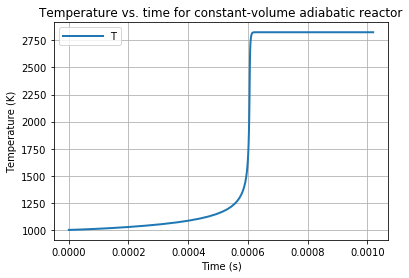

In [18]:
# plot the time evolution of temperature
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature'], label='T', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Temperature (K)',
       title ='Temperature vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_vconst.pdf")

The temperature increases gradually starting from time t=0, in contrast to to the behavior observed for the more detailed mechanism. In this global mechanism, fuel is converted directly into CO and H2O, and CO is subsequently converted to CO2. The ignition delay time computed here is approximately 1000 times faster, compared to that computed using gri30.cti.

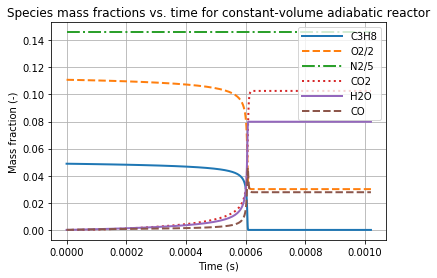

In [19]:
# plot the time evolution of species mass fractions
# individual species mass fractions are scaled so that they can be seen more clearly on a single figure
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['C3H8'],  label='C3H8', ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['O2']/2., label='O2/2', ls='dashed',  lw=2)
ax.plot(timeHistory.index, timeHistory['N2']/5., label='N2/5', ls='dashdot', lw=2)
ax.plot(timeHistory.index, timeHistory['CO2'],   label='CO2',  ls='dotted',  lw=2)
ax.plot(timeHistory.index, timeHistory['H2O'],   label='H2O',  ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['CO'],    label='CO',   ls='dashed',  lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Y_vs_t_vconst.pdf")

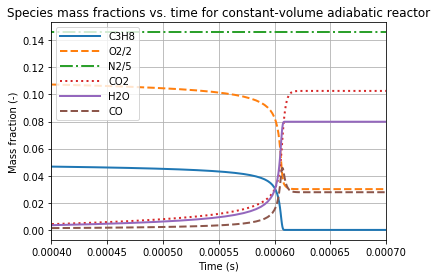

In [20]:
# zoom in around the instant of ignition
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['C3H8'],  label='C3H8', ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['O2']/2., label='O2/2', ls='dashed',  lw=2)
ax.plot(timeHistory.index, timeHistory['N2']/5., label='N2/5', ls='dashdot', lw=2)
ax.plot(timeHistory.index, timeHistory['CO2'],   label='CO2',  ls='dotted',  lw=2)
ax.plot(timeHistory.index, timeHistory['H2O'],   label='H2O',  ls='solid',   lw=2)
ax.plot(timeHistory.index, timeHistory['CO'],    label='CO',   ls='dashed',  lw=2)
ax.set(xlim=(0.0004,0.0007),
       xlabel='Time (s)',
       ylabel='Mass fraction (-)',
       title ='Species mass fractions vs. time for constant-volume adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("Y_vs_t_vconst_zoom.pdf")

The equilibrium mass fraction of H2O is somewhat higher than for gri30.cti, as some of the fuel hydrogen there goes into other species including H2. And the conversion from CO to CO2 is not as complete here compared to the more detailed mechanism (higher CO and lower CO2 here). That is a consequence of the higher equlibrium temperature here, which shifts the equilibrium of reaction r1 in the endothermic direction (more CO, less CO2).

When we get to laminar premixed flames in Chapter 8 of Turns 4th ed., we will revisit this global mechanism. There we will use it for its intended purpose, and within its intended range of thermochemical conditions.